**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from darts import TimeSeries
from darts.metrics import mape
from darts.utils.statistics import check_seasonality
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    XGBModel,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
)
from darts.dataprocessing.transformers import Scaler

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [2]:
raw_df = pd.read_csv("demand-forecasting-kernels-only/train.csv")
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df.set_index("date", inplace=True)
raw_df.head(10)


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



In [3]:
raw_df_gr = raw_df.groupby("store")

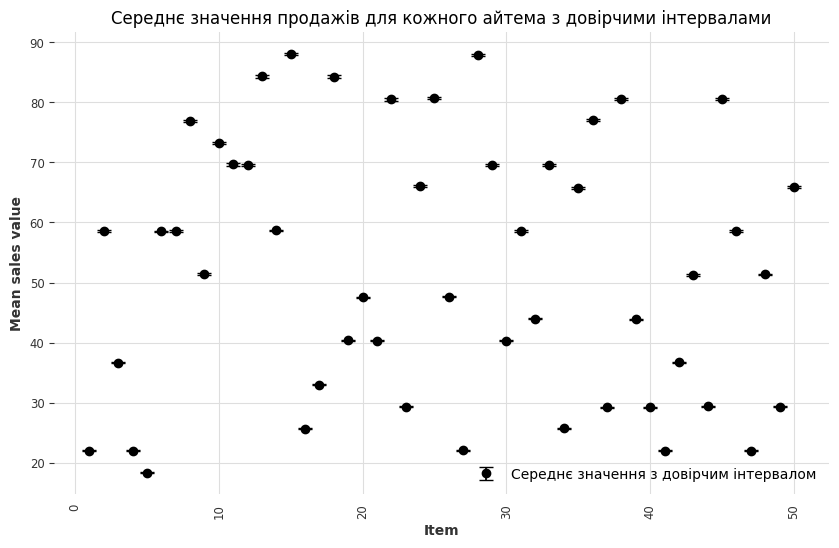

In [4]:
# 1. Графік середнього значення продажів з довірчими інтервалами
item_avg = raw_df.groupby('item')['sales'].mean()
item_std = raw_df.groupby('item')['sales'].std()
item_count = raw_df.groupby('item')['sales'].count()

se = item_std / np.sqrt(item_count)

plt.figure(figsize=(10, 6))
plt.errorbar(item_avg.index, item_avg, yerr=se, fmt='o', capsize=5, label="Середнє значення з довірчим інтервалом")
plt.xlabel('Item')
plt.ylabel('Mean sales value')
plt.title('Середнє значення продажів для кожного айтема з довірчими інтервалами')
plt.xticks(rotation=90)
plt.legend()
plt.show()

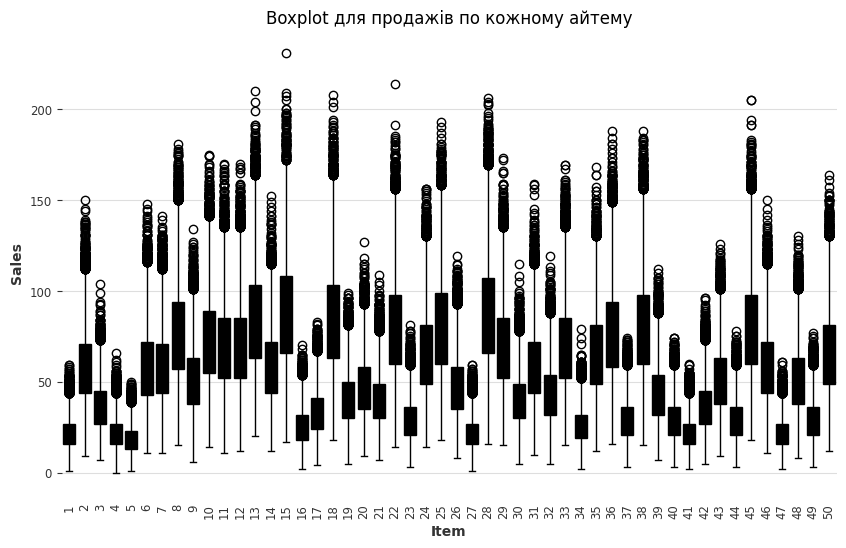

In [5]:
# 2. Boxplot для кожного айтема
plt.figure(figsize=(10, 6))
sns.boxplot(data=raw_df, x='item', y='sales')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.title('Boxplot для продажів по кожному айтему')
plt.xticks(rotation=90)
plt.show()

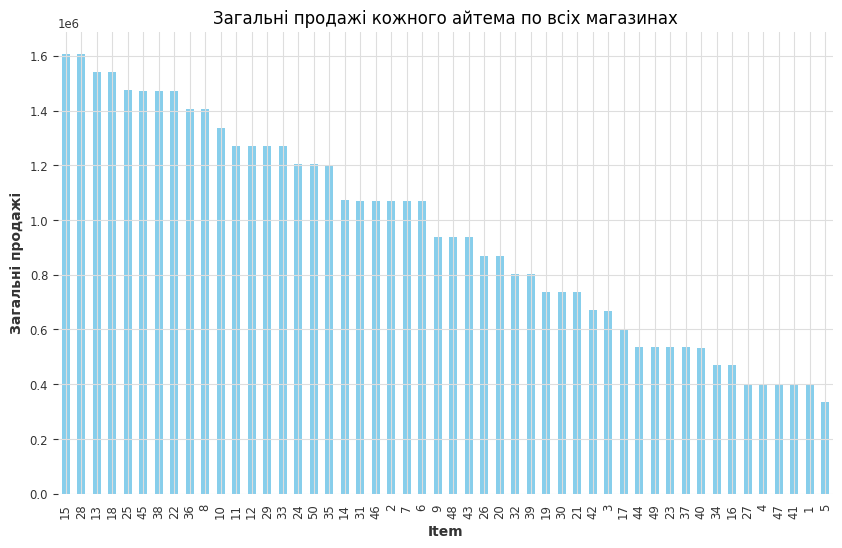

In [6]:
# 3. Bar Plot of Total Sales for Each Item Across All Stores
item_sales = raw_df.groupby('item')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
item_sales.plot(kind='bar', color='skyblue')
plt.xlabel('Item')
plt.ylabel('Загальні продажі')
plt.title('Загальні продажі кожного айтема по всіх магазинах')
plt.xticks(rotation=90)
plt.show()

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [7]:
df_filtered = raw_df[(raw_df['item'] == 1) & (raw_df['store'] == 1)]
decomposition = seasonal_decompose(df_filtered['sales'], model='additive', period=7)

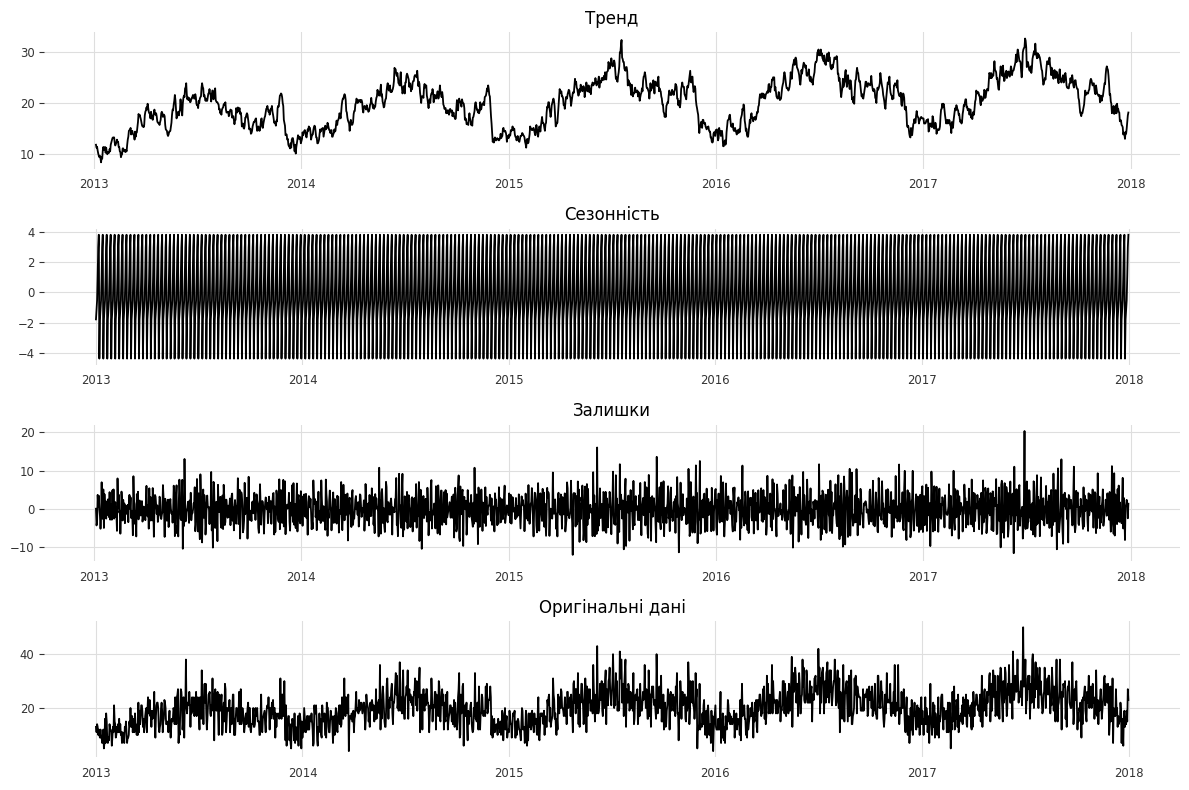

In [8]:
# Візуалізація компонент
plt.figure(figsize=(12, 8))

# Тренд
plt.subplot(4, 1, 1)
plt.plot(decomposition.trend)
plt.title('Тренд')

# Сезонність
plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal)
plt.title('Сезонність')

# Залишки
plt.subplot(4, 1, 3)
plt.plot(decomposition.resid)
plt.title('Залишки')

# Оригінальні дані
plt.subplot(4, 1, 4)
plt.plot(df_filtered['sales'])
plt.title('Оригінальні дані')

plt.tight_layout()
plt.show()

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [9]:
ts_sales = TimeSeries.from_series(df_filtered['sales'])

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [10]:
ts_train, ts_val = ts_sales.split_before(pd.Timestamp('2017-10-01'))

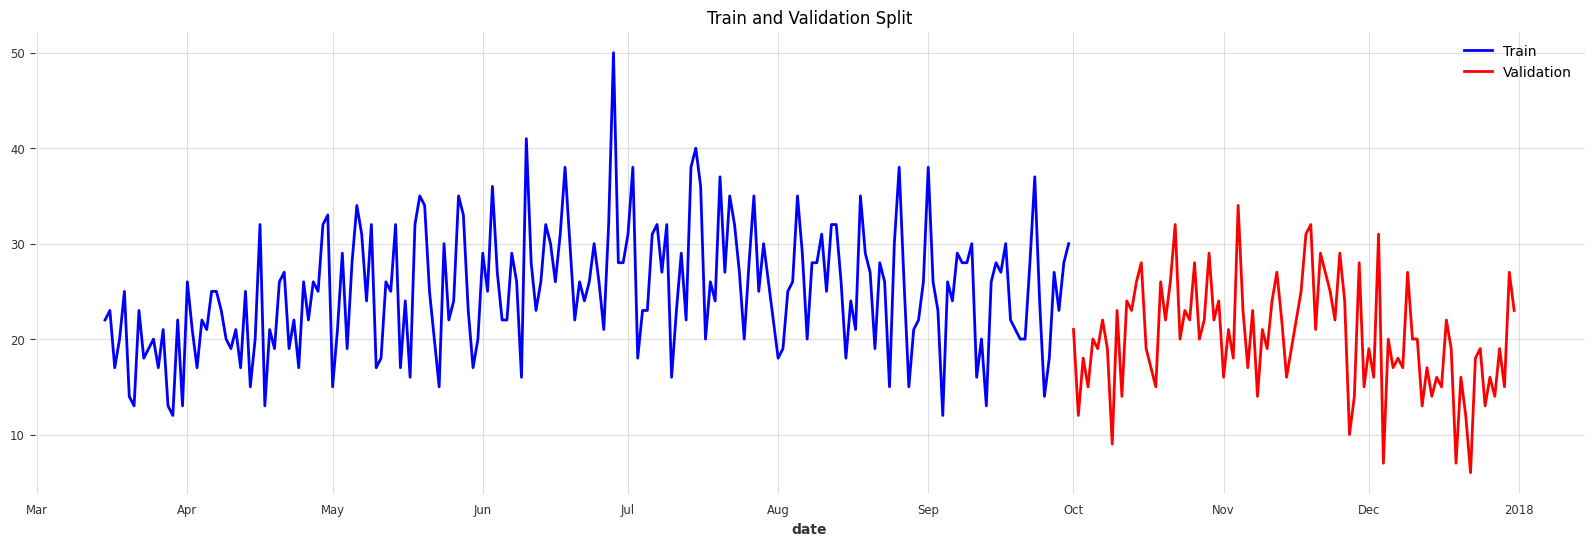

In [11]:
plt.figure(figsize=(20, 6))
ts_train[-200:].plot(label='Train', color='blue')
ts_val.plot(label='Validation', color='red')

plt.title('Train and Validation Split')
plt.legend()
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

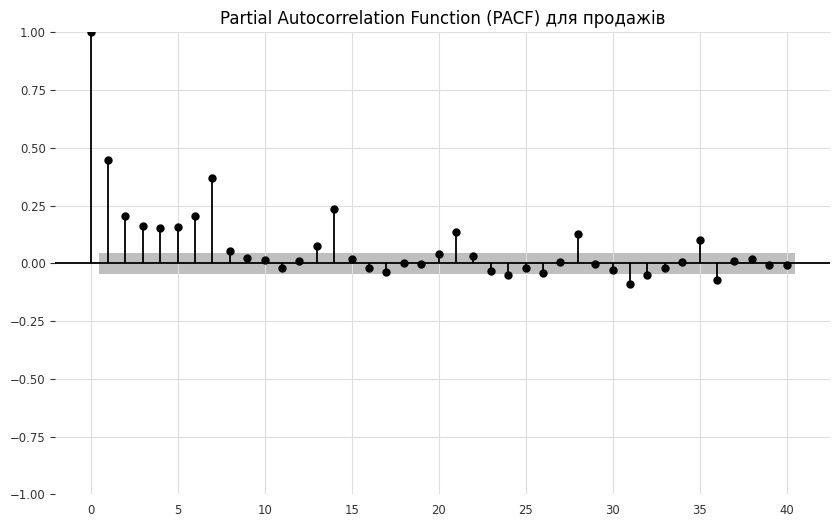

In [12]:
# Створюємо PACF для нашого часового ряду
plt.figure(figsize=(10, 6))
plot_pacf(ts_sales.values(), lags=40, method='ywm', ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) для продажів')
plt.show()

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [13]:
is_seasonal, seasonality_period = check_seasonality(ts_sales)

print(f"Чи є сезональність: {is_seasonal}")
if is_seasonal:
    print(f"Виявлений період сезональності: {seasonality_period}")

Чи є сезональність: True
Виявлений період сезональності: 7


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

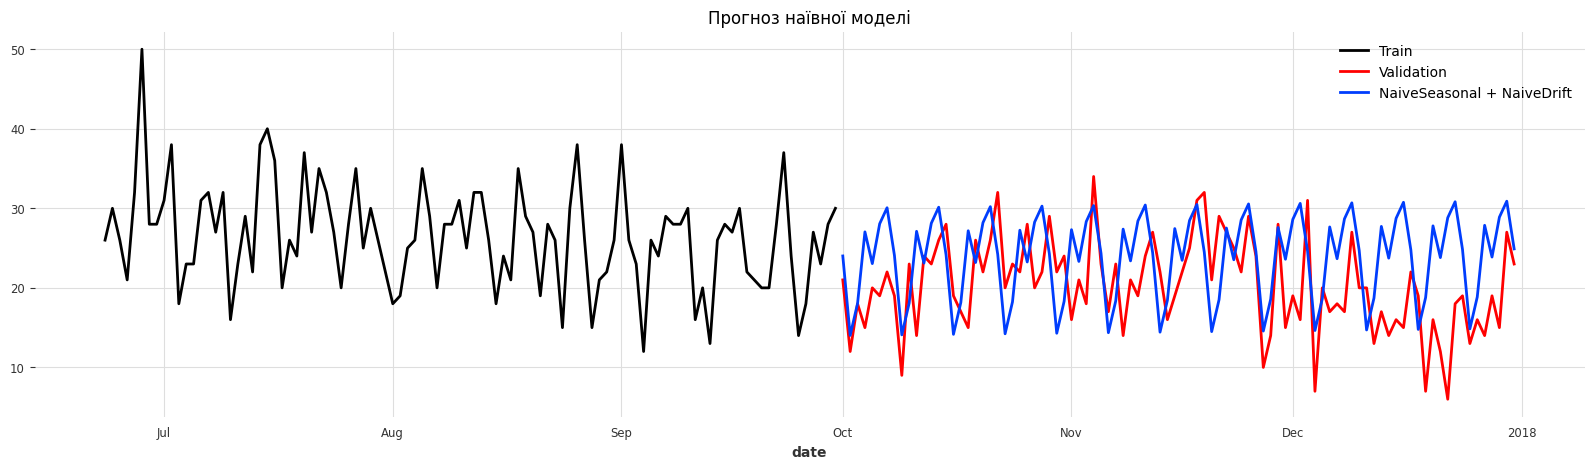

In [14]:
forecast_horizon = len(ts_val)

model_seasonal = NaiveSeasonal(K=seasonality_period)
model_drift = NaiveDrift()

model_seasonal.fit(ts_train)
model_drift.fit(ts_train)

forecast_seasonal = model_seasonal.predict(forecast_horizon)
forecast_drift = model_drift.predict(forecast_horizon)

forecast_combined = forecast_seasonal + forecast_drift - ts_train.last_value()

plt.figure(figsize=(20, 5))
ts_train[-100:].plot(label="Train")
ts_val.plot(label="Validation", color="red")
forecast_combined.plot(label="NaiveSeasonal + NaiveDrift")
plt.legend()
plt.title("Прогноз наївної моделі")
plt.show()


9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [15]:
mape_score = mape(ts_val, forecast_combined)

print(f"MAPE for Naïve Model: {mape_score:.2f}%")

MAPE for Naïve Model: 39.91%


10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [16]:
def enrich_with_date_features(df):
  df["quarter"] = df['date'].dt.quarter
  df["year"] = df['date'].dt.year
  df["month"] = df['date'].dt.month
  df["dayofyear"] = df['date'].dt.dayofyear
  df["dayofweek"] = df['date'].dt.dayofweek
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  return df

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

def plot_results(series, forecast):
  # Візуалізація результатів
  plt.figure(figsize=(20, 5))
  series[-200:].plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

In [17]:
# Додавання ознак дати
train_transformed = enrich_with_date_features(ts_train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(ts_val.pd_dataframe().reset_index())

# Convert back to TimeSeries
# ts_train = TimeSeries.from_dataframe(train_transformed, time_col="date", value_cols=["sales"])
# ts_val = TimeSeries.from_dataframe(val_transformed, time_col="date", value_cols=["sales"])

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(ts_train)
val_transformed = scaler.transform(ts_val)

In [18]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    "lags": [7, 14, 30],  
    "n_estimators": [50, 100, 200],  
    "max_depth": [3, 5, 7],  
    "learning_rate": [0.01, 0.1, 0.2],  
    "subsample": [0.6, 0.8, 1.0],  
    "colsample_bytree": [0.6, 0.8, 1.0]  
}

best_mape = float("inf")
best_params = None

# Loop through all possible combinations
for params in ParameterGrid(param_grid):
    model = XGBModel(**params, output_chunk_length=1)
    model.fit(train_transformed)
    
    pred = model.predict(n=len(val_transformed))
    error = mape(val_transformed, pred)
    
    if error < best_mape:
        best_mape = error
        best_params = params

print("Best Params:", best_params)
print("Best MAPE:", best_mape)

Best Params: {'colsample_bytree': 0.8, 'lags': 30, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Best MAPE: 38.06262270653132


model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 24.63%


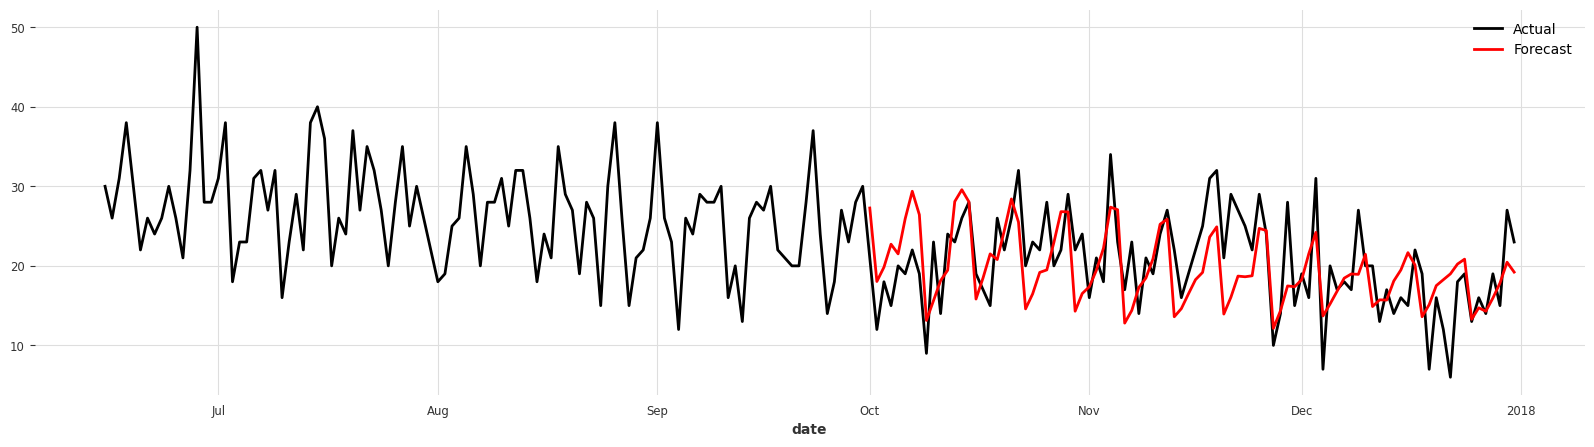

In [19]:
xgb_model = XGBModel(**best_params)

# Тренування моделі
xgb_model.fit(train_transformed)
xgb_pred = xgb_model.predict(len(val_transformed))

xgb_forecast = scaler.inverse_transform(xgb_pred)

eval_forecast(xgb_model, ts_val, xgb_forecast)
plot_results(ts_sales, xgb_forecast)

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

MAPE: 8685.814673060653


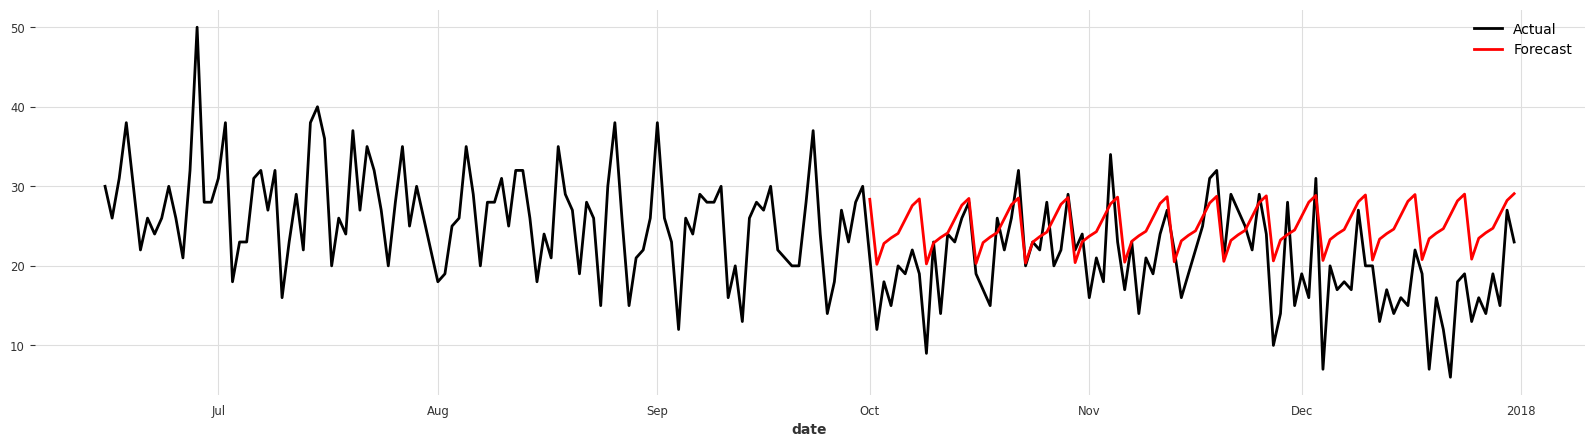

In [20]:
exp_model = ExponentialSmoothing()
exp_model.fit(train_transformed)

exp_pred = exp_model.predict(len(val_transformed))
exp_forecast = scaler.inverse_transform(exp_pred)

error = mape(val_transformed, exp_forecast)
print(f"MAPE: {error}")

plot_results(ts_sales, exp_forecast)


12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

MAPE for ARIMA: 8595.65039997366


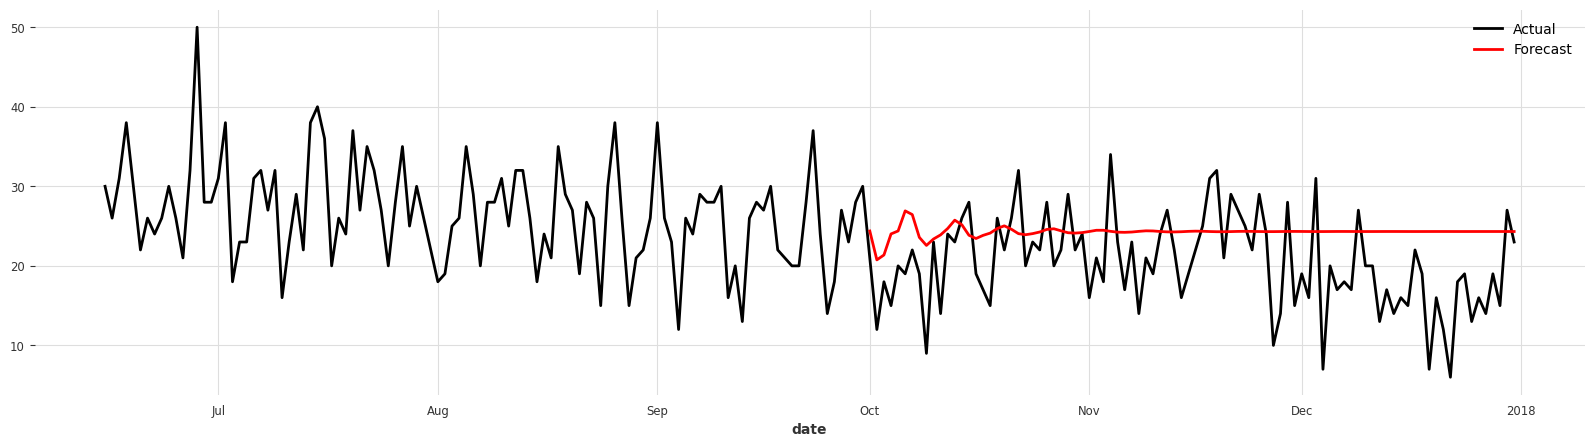

In [21]:
p, d, q = 12, 1, 0

arima_model = ARIMA(p=p, d=d, q=q)
arima_model.fit(train_transformed)

arima_pred = arima_model.predict(len(val_transformed))
arima_forecast = scaler.inverse_transform(arima_pred)

error_arima = mape(val_transformed, arima_forecast)
print(f"MAPE for ARIMA: {error_arima}")

plot_results(ts_sales, arima_forecast)

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

/Users/vasyl/Projects/private/ml_learning/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vasyl/Projects/private/ml_learning/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vasyl/Projects/private/ml_learning/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vasyl/Projects/private/ml_learning/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vasyl/Projects/private/ml_learning/.venv/lib/python3.10/site-pack

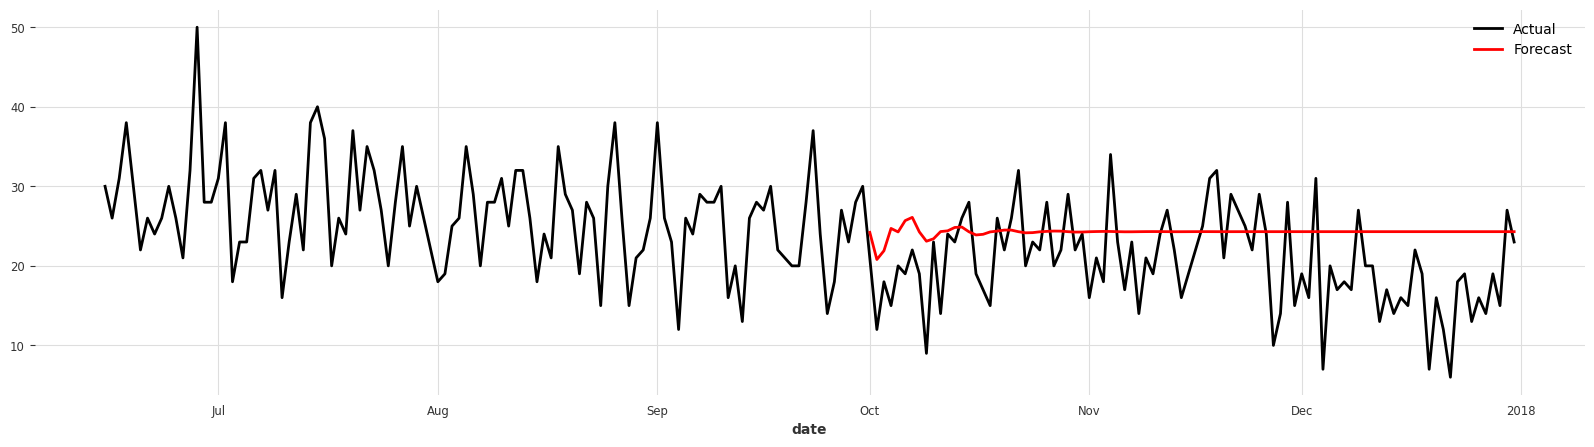

In [22]:
model = AutoARIMA(start_p=1, max_p=48, start_q=1)
model.fit(train_transformed)

# Прогнозування
auto_arima_pred = model.predict(len(val_transformed))
auto_arima_forecast = scaler.inverse_transform(auto_arima_pred)

# Візуалізація результатів
plot_results(ts_sales, auto_arima_forecast)

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [26]:
# наша найкраща модель
model = XGBModel(**best_params)

# Тренування моделі
model.fit(train_transformed)

pred = model.predict(len(val_transformed))
forecast = scaler.inverse_transform(pred)

eval_forecast(model, val_transformed, forecast)

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 6542.55%


6542.549587936655

historical forecasts:   0%|          | 0/123 [00:00<?, ?it/s]

MAPE = 35.92%


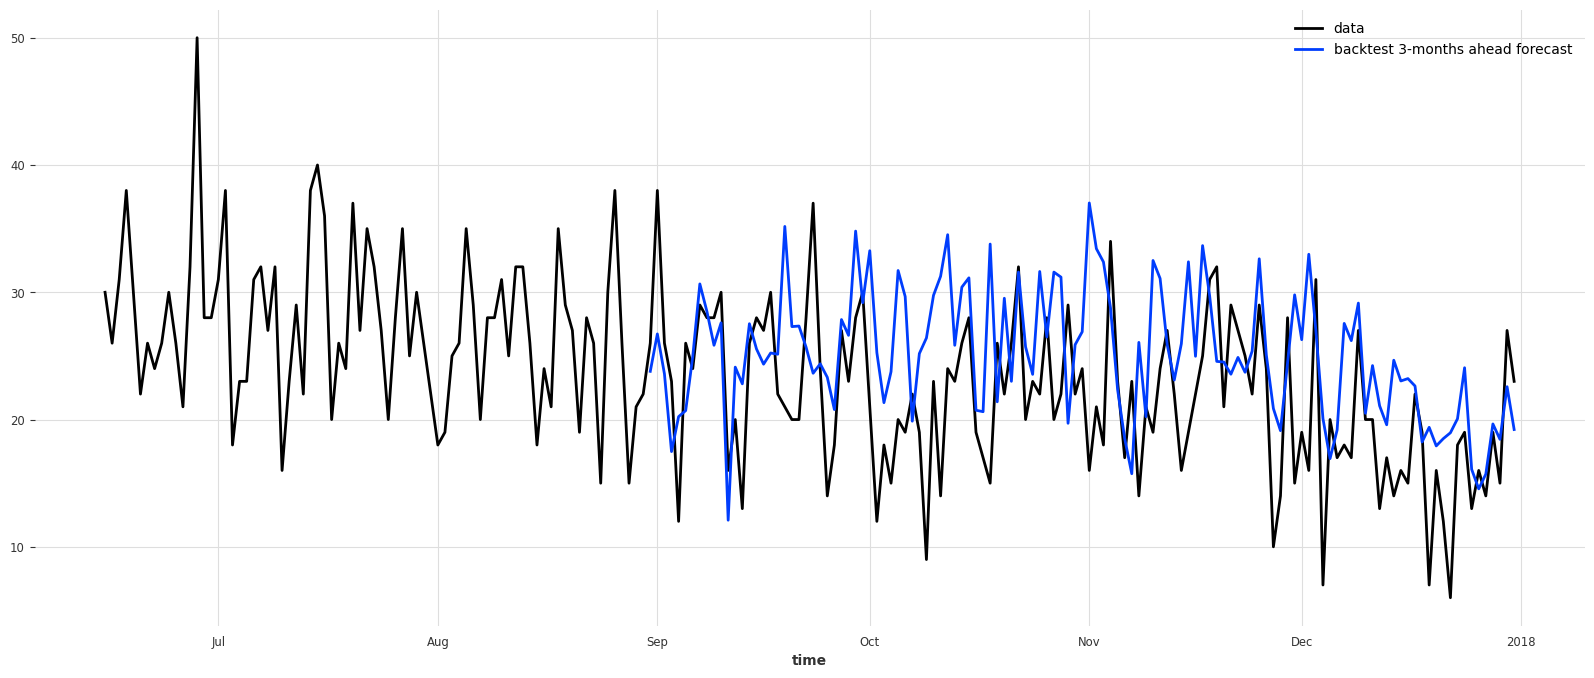

In [33]:
hfc_params = {
    "series": ts_sales,
    "start": pd.Timestamp("2017-06-01"),
    "forecast_horizon": forecast_horizon,
    "verbose": True,
    "show_warnings": False
}

historical_fcast = model.historical_forecasts(last_points_only=True, **hfc_params)

plt.figure(figsize=(20, 8))
ts_sales[-200:].plot(label="data")
historical_fcast.plot(label="backtest 3-months ahead forecast")
print(f"MAPE = {mape(ts_sales, historical_fcast):.2f}%")